In [1]:
import sys, os
sys.path.append(os.path.abspath("../../"))

I checked in the automated tests that the elements and non elements return the exact same thing (where comparisons can be made) in all cases, so I don't need to include the non-elements here.

In [2]:
from core_enrich_ia_elts_cluster_discrete import lib as core
from snia_enrich_ia_elts_cluster_discrete import lib as snia_discrete
from snia_enrich_ia_elts_cluster import lib as snia_continuous

In [3]:
from collections import defaultdict
import numpy as np
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate
from tqdm import tqdm_notebook as tqdm

import betterplotlib as bpl
bpl.presentation_style()

In [4]:
bpl.presentation_style()

In [5]:
core.detailed_enrichment_init()
snia_discrete.detailed_enrichment_init()
snia_continuous.detailed_enrichment_init()

In [6]:
elts = ["C", "N", "O", "Mg", "S", "Ca", "Fe", "Z"]

In [7]:
idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
        "Z": 7, "E": 8, "N_SN_left": 9}

In [8]:
E_0 = 2E51  # default SN energy

In [9]:
class SN(object):
    def __init__(self, c_code, name):
        self.core = c_code
        self.name = name
        
        self.idxs = idxs
    
    def snia_number(self, age, dt, t_start):
        return self.core.get_sn_ia_number_py(age, dt, t_start)
    
    def snia_ejecta(self, unexploded_sn, age, dt, m_star, z, t_start, elt):
        # to get the number of supernovae we have to be clever. We divide the energy
        # by the energy per supernova
        if elt == "N_SN":
            return self.snia_ejecta(unexploded_sn, age, dt, m_star, z, t_start, "E") / E_0
        return self.core.sn_ia_core_py(unexploded_sn, age, dt, m_star, z, t_start)[self.idxs[elt]]

In [10]:
discrete = SN(snia_discrete, "Discrete")
continuous = SN(snia_continuous, "Continuous")

all_snia = [discrete, continuous]

In [11]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.1, 50, total_mass=1)

In [12]:
dt = 1E6
times = np.arange(dt, 14E9, dt)

# check the cumulative number of supernovae

First compare the number of SN returned by the C code to the one from the internal function to do this. The analytic form comes from https://nbviewer.jupyter.org/github/gillenbrown/Tabulation/blob/master/notebooks/sn_Ia.ipynb then is analytically integrated.

In [19]:
def expected_snia_rate(age, z):
    t_start = lt.lifetime(8.0, z)
    if age < t_start:
        return 0
    return 1.6E-3 * 2.3480851917 * age**(-1.13)

def expected_snia_n_sn(age, z):
    """Analytic integral"""
    t_start = lt.lifetime(8.0, z)
    if age < t_start:
        return 0
    return (1.6E-3 * 2.3480851917 / 0.13) * (t_start**(-0.13) - age**(-0.13))

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


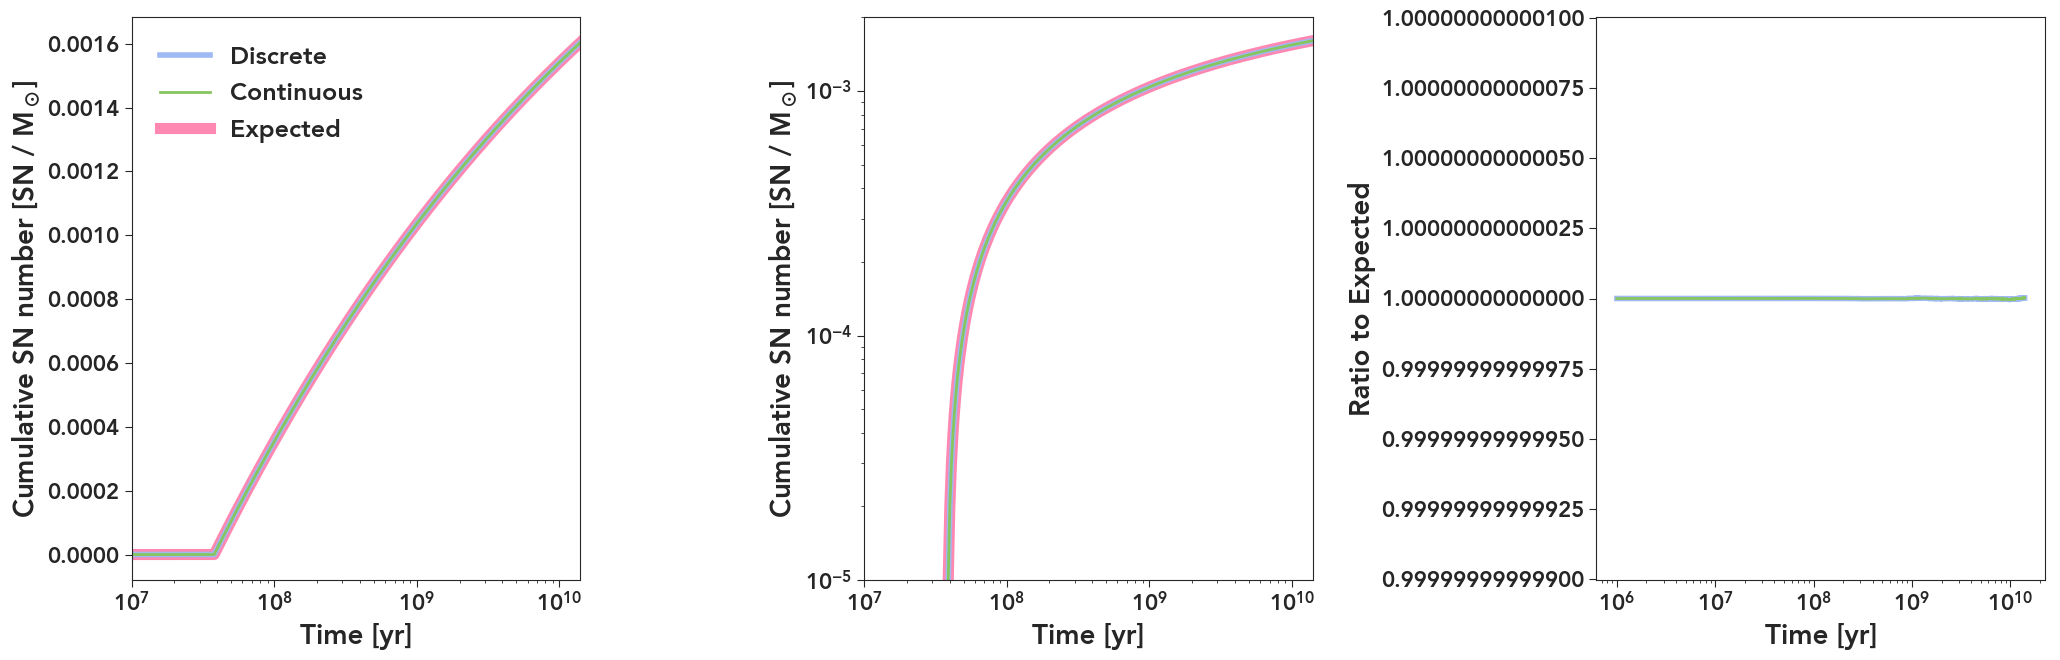

In [14]:
fig, axs = bpl.subplots(ncols=3, figsize=[21, 7])

z = 0.02
age_8 = lt.lifetime(8.0, z)
lw = 6

expected_n_sn = [expected_snia_n_sn(t, z) for t in times]

for sn in all_snia:
    lw -= 2
    # Here the C function gives the number of SN in an iterval starting 
    # at time t, while we want to plot the number once we've reached t, 
    # so we have to use the previous time in the function call. This
    # can be accomplished by starting at zero, then not using the last time
    n_sn = [sn.snia_number(0, dt, age_8)]
    for t in times[:-1]:
        n_sn.append(n_sn[-1] + sn.snia_number(t, dt, age_8))
        
    for ax in axs[:2]:
        ax.plot(times, n_sn, lw=lw, label=sn.name)
        
    ratio = [n_sn[idx] / expected_n_sn[idx] if expected_n_sn[idx] > 0 else 1
             for idx in range(len(times))]
    axs[2].plot(times, ratio, lw=lw, label=sn.name)
    
for ax in axs[:2]:
    ax.plot(times, expected_n_sn, lw=8, label='Expected', zorder=0)

for ax in axs[:2]:
    ax.set_xscale("log")
    ax.set_limits(1E7, 14E9)
    ax.add_labels("Time [yr]", "Cumulative SN number [SN / $M_\odot$]")
axs[0].legend()
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[1].set_limits(y_min=1E-5, y_max=2E-3)
axs[2].add_labels("Time [yr]", "Ratio to Expected")

This looks great. We'll do a simple check against the analytic rate to make sure it's consistent. I'll divide number of supernovae by the timestep length to get an approximate rate. This won't exactly match, but will at least be a first order check.

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


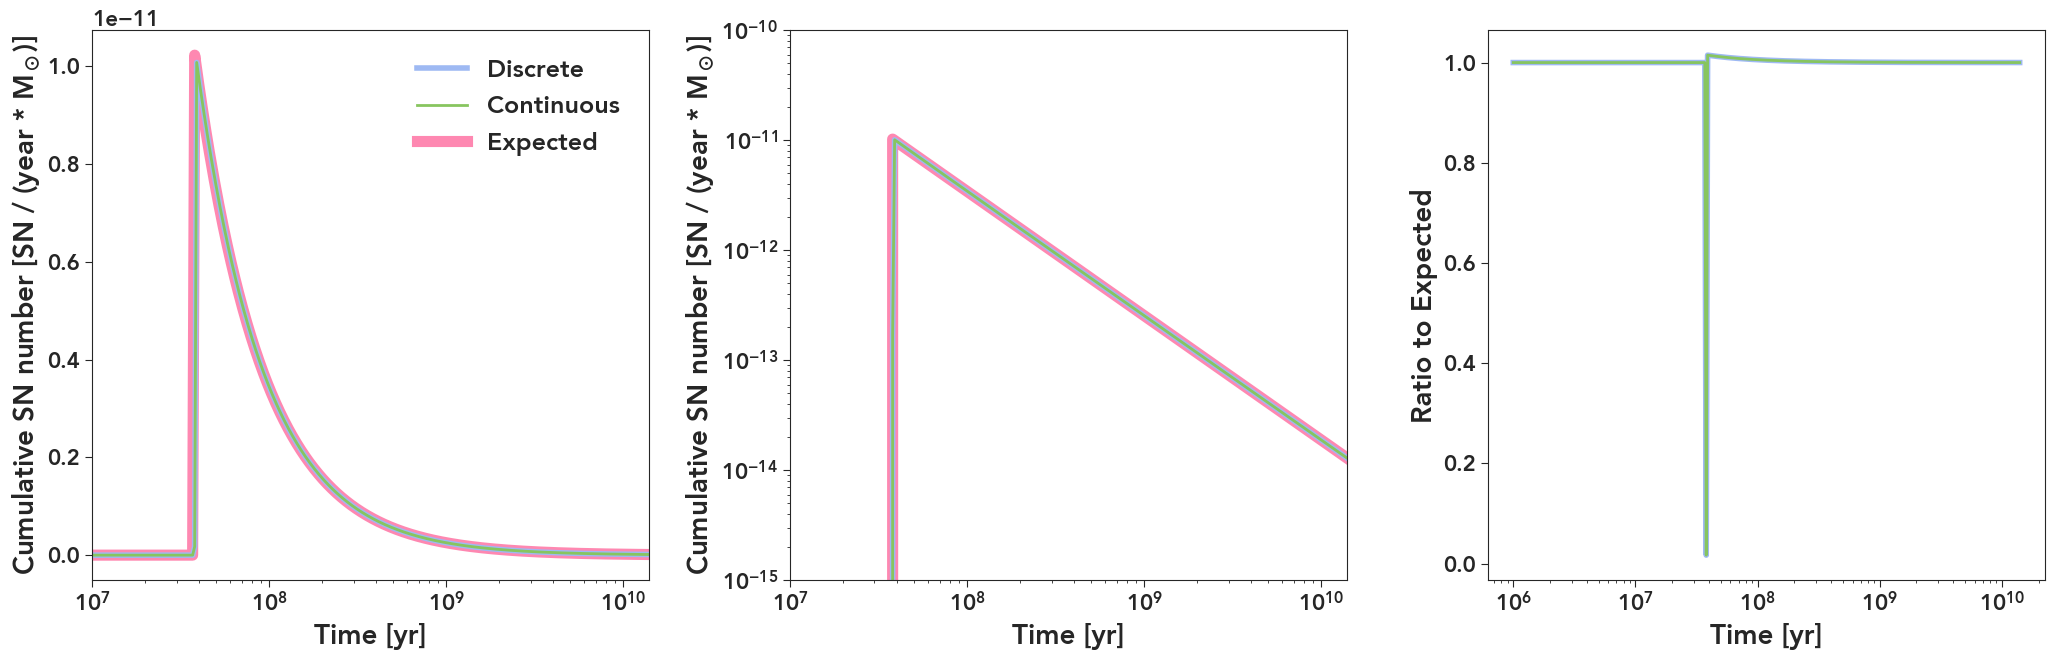

In [22]:
fig, axs = bpl.subplots(ncols=3, figsize=[21, 7])

z = 0.02
age_8 = lt.lifetime(8.0, z)
lw = 6

expected_sn_rate = [expected_snia_rate(t, z) for t in times]

for sn in all_snia:
    lw -= 2
    # Here the C function gives the number of SN in an iterval starting 
    # at time t, while we want to plot the number once we've reached t, 
    # so we have to use the previous time in the function call. This
    # can be accomplished by starting at zero, then not using the last time
    sn_rate = [sn.snia_number(0, dt, age_8) / dt]
    for t in times[:-1]:
        sn_rate.append(sn.snia_number(t, dt, age_8) / dt)
        
    for ax in axs[:2]:
        ax.plot(times, sn_rate, lw=lw, label=sn.name)
        
    ratio = [sn_rate[idx] / expected_sn_rate[idx] if expected_sn_rate[idx] > 0 else 1
             for idx in range(len(times))]
    axs[2].plot(times, ratio, lw=lw, label=sn.name)
    
for ax in axs[:2]:
    ax.plot(times, expected_sn_rate, lw=8, label='Expected', zorder=0)

for ax in axs[:2]:
    ax.set_xscale("log")
    ax.set_limits(1E7, 14E9)
    ax.add_labels("Time [yr]", "Cumulative SN number [SN / (year * $M_\odot$)]")
axs[0].legend()
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[1].set_limits(y_min=1E-15, y_max=1E-10)
axs[2].add_labels("Time [yr]", "Ratio to Expected")

This looks good!

We should then make sure that the actual number of supernovae agrees with this. This is easy for the continuous case, but for the discrete case we have to keep track of the number of leftover supernovae.

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


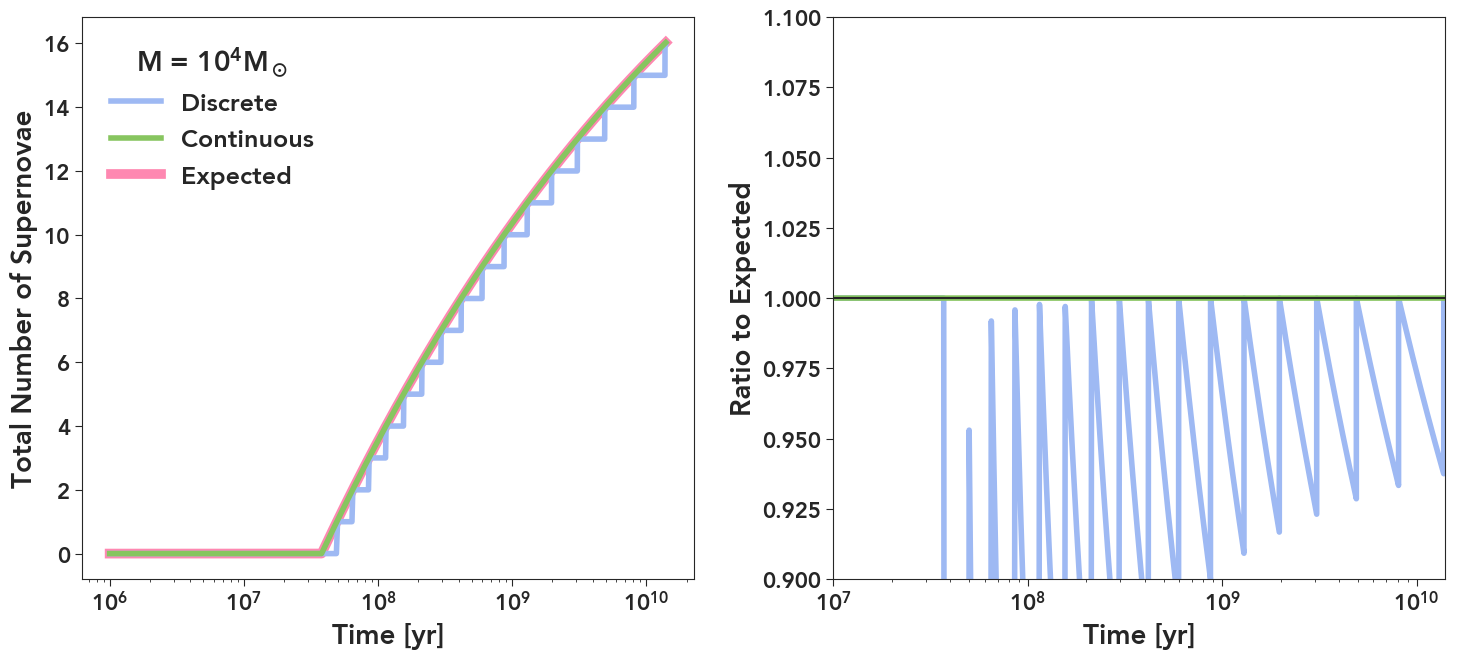

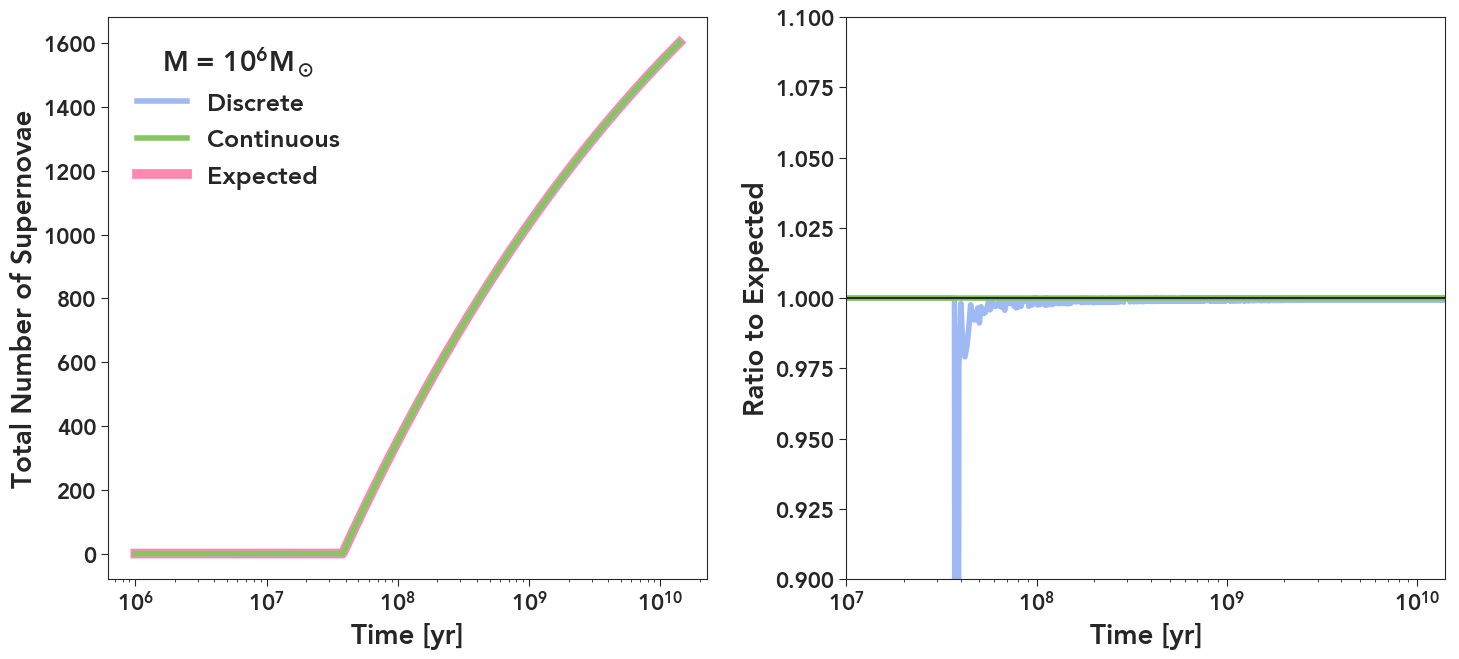

In [15]:
z = 0.02
age_8 = lt.lifetime(8.0, z)

for m in [1E4, 1E6]:
    fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])
    lw = 4
    
    expected_n_sn = [expected_snia_n_sn(t, z) * m for t in times]

    for sn in all_snia:
        # here again we need to be careful with times, because the C function 
        # gives the number of SN in an iterval starting at time t, while we 
        # want to plot the number once we've reached t
        n_unexploded = 0  # starting value
        n_sn_total =  [sn.snia_ejecta(n_unexploded, 0, dt, m, z, age_8, "N_SN")]
        n_unexploded = sn.snia_ejecta(n_unexploded, 0, dt, m, z, age_8, "N_SN_left")
        
        for t in times[:-1]:
            n_sn_now = sn.snia_ejecta(n_unexploded, t, dt, m, z, age_8, "N_SN")
            n_unexploded = sn.snia_ejecta(n_unexploded, t, dt, m, z, age_8, "N_SN_left")

            n_sn_total.append(n_sn_total[-1] + n_sn_now)

        axs[0].plot(times, n_sn_total, lw=lw, label=sn.name)

        ratio = [n_sn_total[idx] / expected_n_sn[idx] if expected_n_sn[idx] > 0 else 1 
                 for idx in range(len(times))]
        axs[1].plot(times, ratio, lw=lw, label=sn.name)

    axs[0].plot(times, expected_n_sn, lw=7, label='Expected', zorder=0)

    for ax in axs:
        ax.set_xscale("log")
    
    axs[0].add_labels("Time [yr]", "Total Number of Supernovae")
    axs[1].add_labels("Time [yr]", "Ratio to Expected")
    axs[0].legend(loc=2, title="M = $10^{:.0f} M_\odot$".format(np.log10(m)))
    axs[1].set_limits(1E7, 14E9, 0.9, 1.1)
    axs[1].axhline(1.0, zorder=10)

This also looks good, meaning that the number of SN we get out matches what we expect from the analytical form. Next let's look at the metallicity variations. I'll do the continuous case since it's cleaner.

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


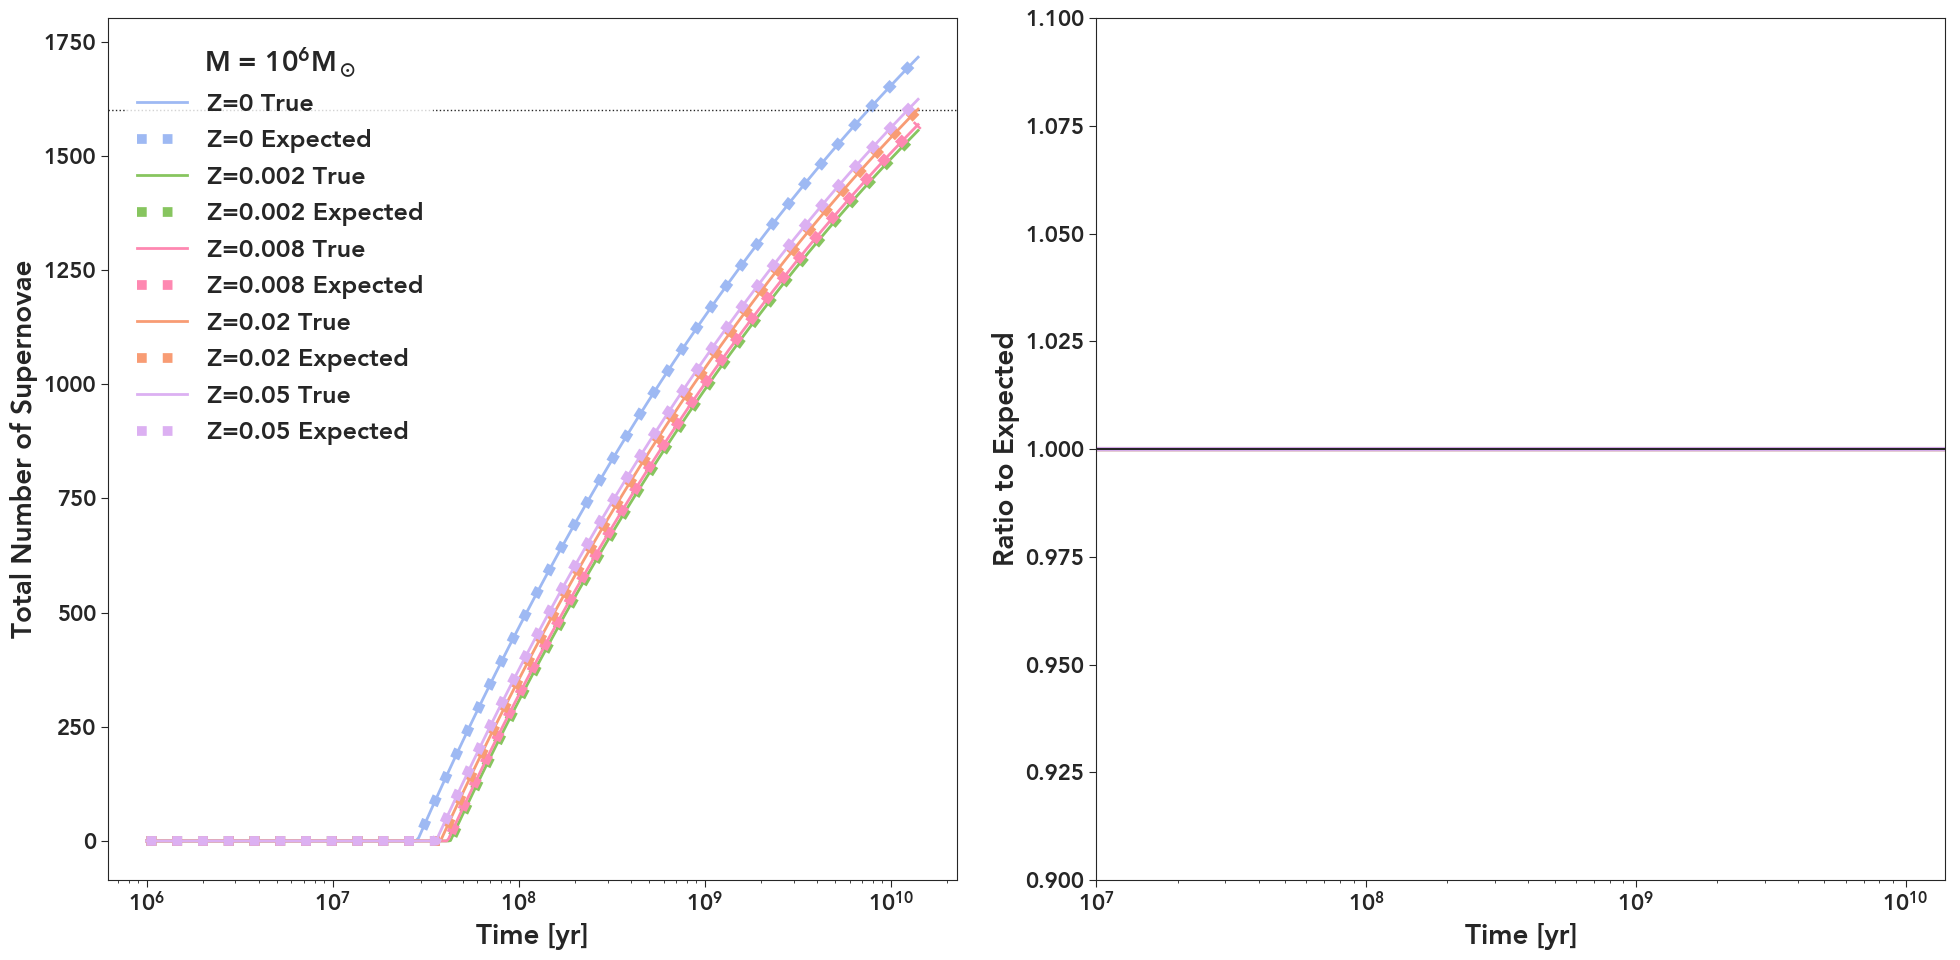

In [16]:
m = 1E6

fig, axs = bpl.subplots(ncols=2, figsize=[20, 10])
for idx, z in enumerate([0, 0.002, 0.008, 0.02, 0.05]):
    age_8 = lt.lifetime(8.0, z)
    
    expected_n_sn = [expected_snia_n_sn(t, z) * m for t in times]

    # here again we need to be careful with times, because the C function 
    # gives the number of SN in an iterval starting at time t, while we 
    # want to plot the number once we've reached t
    n_unexploded = 0  # starting value
    n_sn_total =  [continuous.snia_ejecta(n_unexploded, 0, dt, m, z, age_8, "N_SN")]
    n_unexploded = continuous.snia_ejecta(n_unexploded, 0, dt, m, z, age_8, "N_SN_left")

    for t in times[:-1]:
        n_sn_now = continuous.snia_ejecta(n_unexploded, t, dt, m, z, age_8, "N_SN")
        n_unexploded = continuous.snia_ejecta(n_unexploded, t, dt, m, z, age_8, "N_SN_left")

        n_sn_total.append(n_sn_total[-1] + n_sn_now)

    axs[0].plot(times, n_sn_total, lw=2, label="Z={} True".format(z), zorder=idx*5, c=bpl.color_cycle[idx])

    ratio = [n_sn_total[idx] / expected_n_sn[idx] if expected_n_sn[idx] > 0 else 1 
             for idx in range(len(times))]
    axs[1].plot(times, ratio, lw=3)

    axs[0].plot(times, expected_n_sn, lw=7, ls=":", label="Z={} Expected".format(z), zorder=idx*5-1, c=bpl.color_cycle[idx])

for ax in axs:
    ax.set_xscale("log")

axs[0].add_labels("Time [yr]", "Total Number of Supernovae")
axs[1].add_labels("Time [yr]", "Ratio to Expected")
axs[0].legend(loc=2, title="M = $10^{:.0f} M_\odot$".format(np.log10(m)))
axs[1].set_limits(1E7, 14E9, 0.9, 1.1)
axs[0].axhline(1.6E3, ls=":", c=bpl.almost_black, lw=1)
axs[1].axhline(1.0, zorder=10)

This looks great. The number of SN depends on metallicity because of the DTD, but the solar metallicity one matches the expected value.

Next let's look at the yields. Since we know we're getting the correct number of supernovae out, we can divide by that to get the yield from each SN. This should be constant over all time.

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


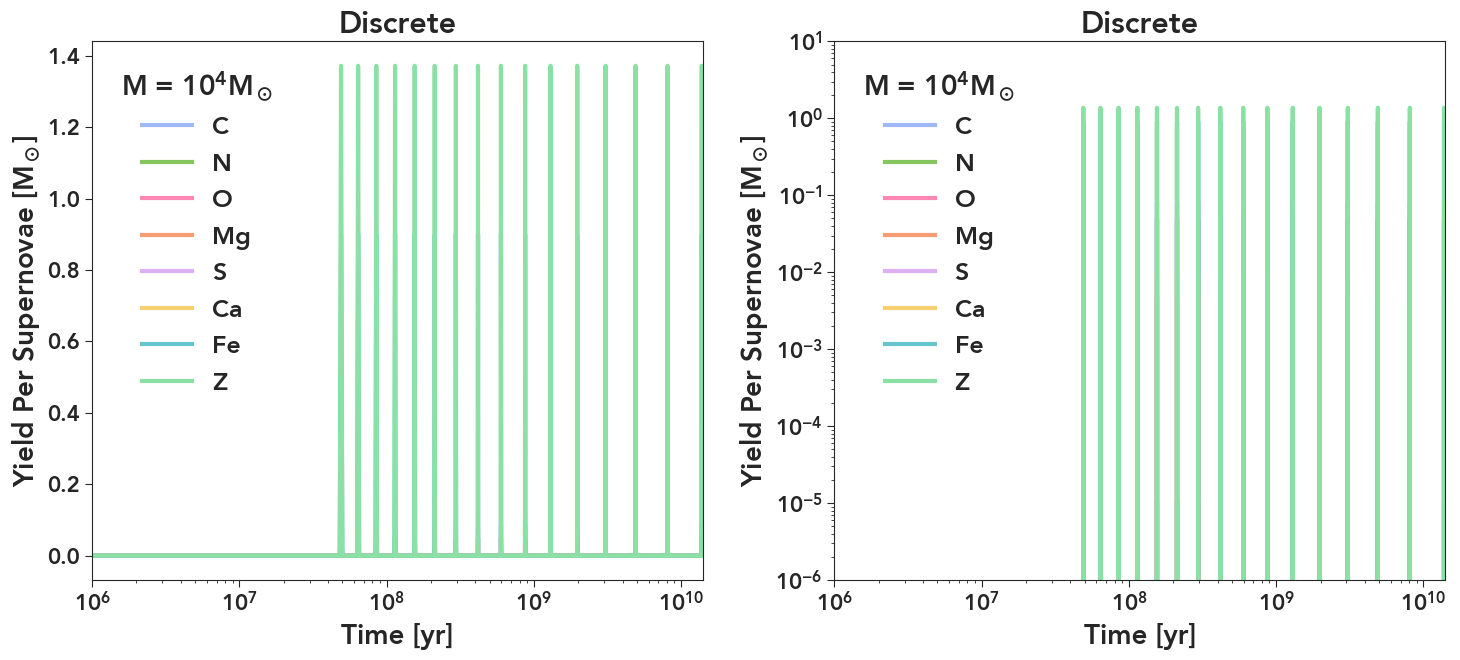

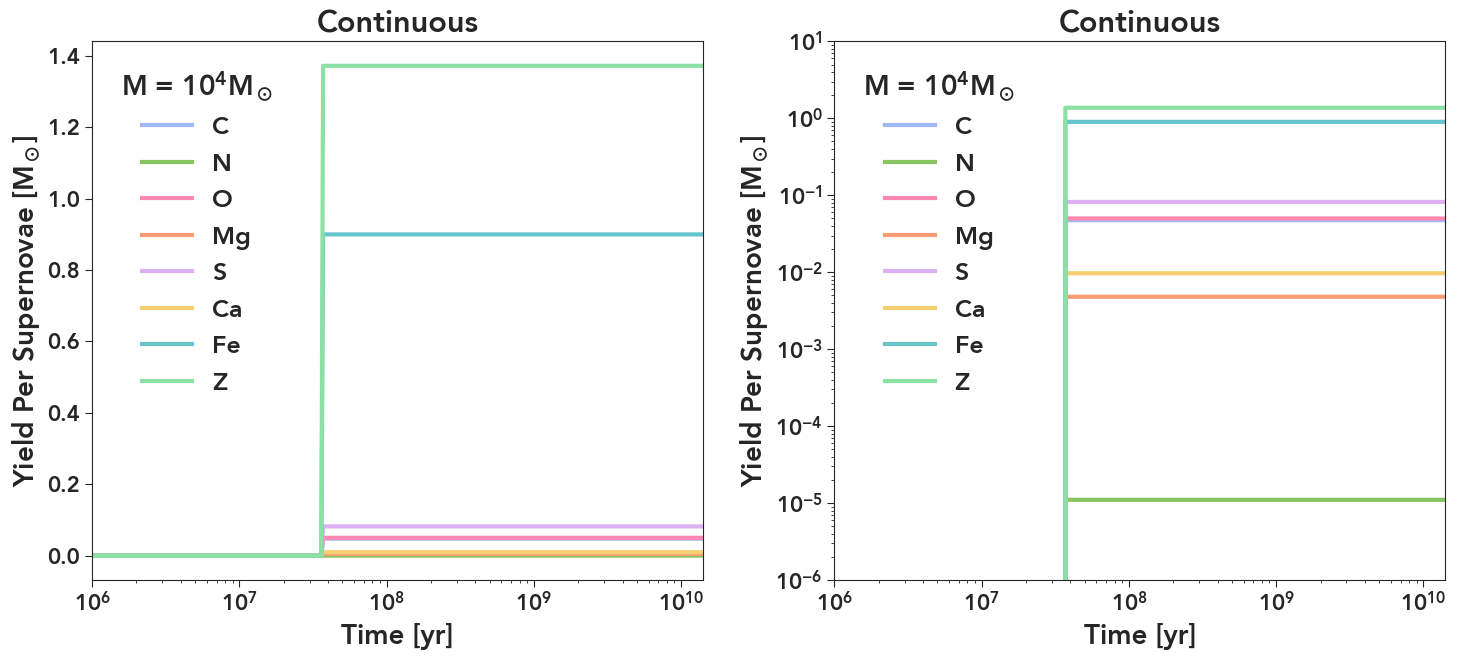

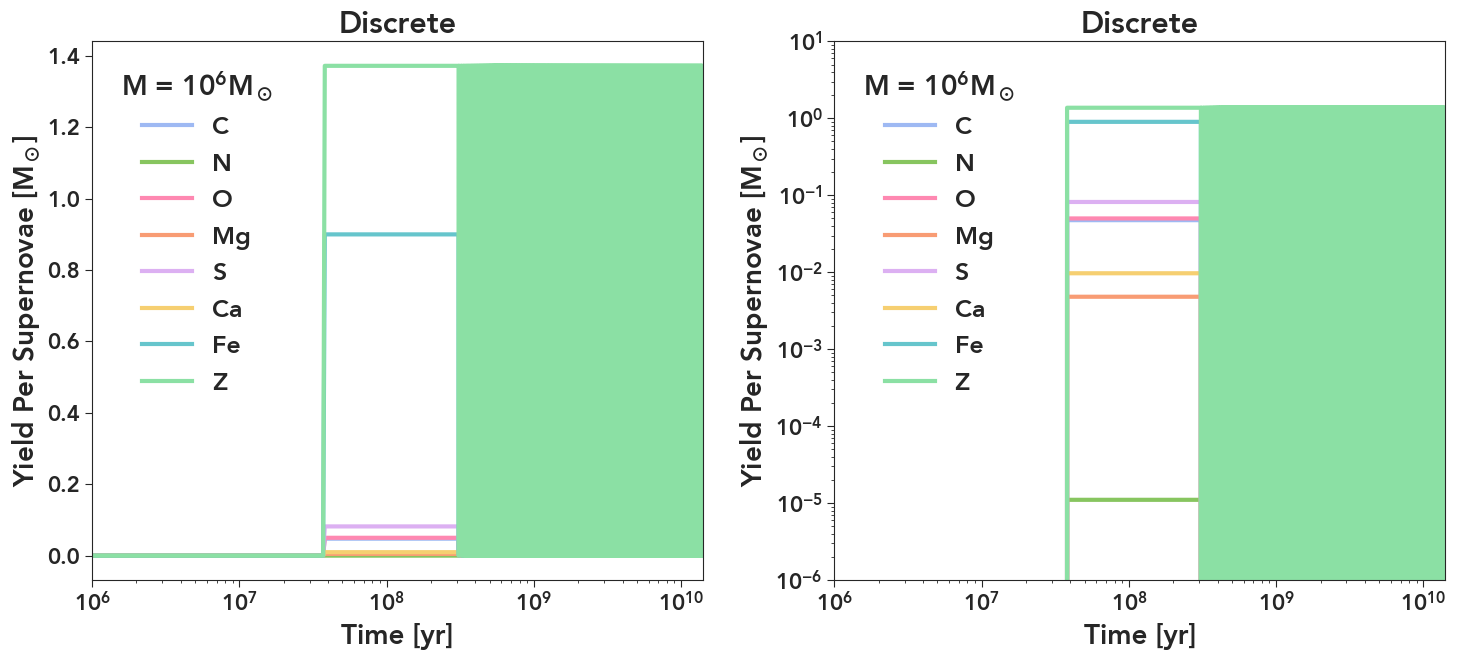

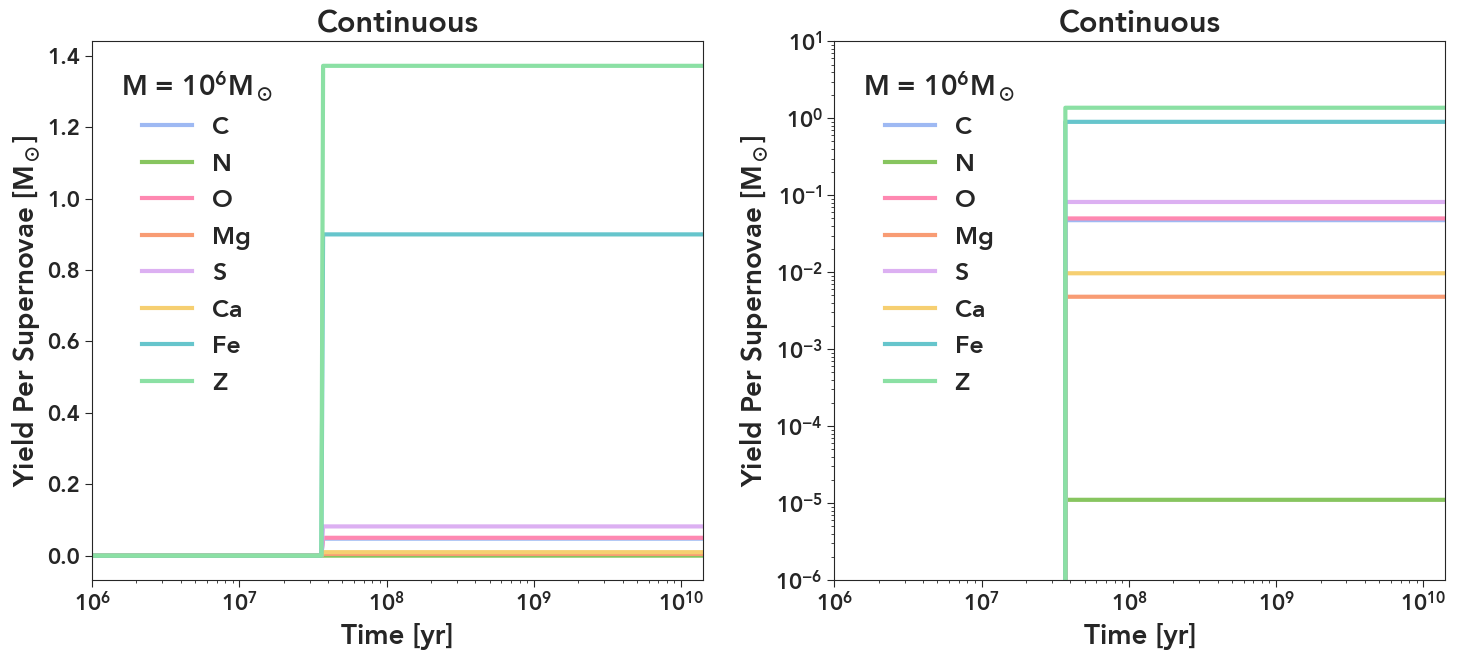

In [17]:
z = 0.02
age_8 = lt.lifetime(8.0, z)

for m in [1E4, 1E6]:
    for sn in all_snia:
        fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])

        yield_per_sn = defaultdict(list)
        n_unexploded = 0
        for t in times:
            n_sn_now = sn.snia_ejecta(n_unexploded, t, dt, m, z, age_8, "N_SN")

            for elt in elts:
                this_elt_yield = sn.snia_ejecta(n_unexploded, t, dt, m, z, age_8, elt)
                if n_sn_now > 0:
                    yield_per_sn[elt].append(this_elt_yield / n_sn_now)
                else:
                    yield_per_sn[elt].append(0)
                    
            n_unexploded = sn.snia_ejecta(n_unexploded, t, dt, m, z, age_8, "N_SN_left")

        for elt in elts:
            for ax in axs:
                ax.plot(times, yield_per_sn[elt], alpha=1, label=elt)

        for ax in axs:
            ax.set_xscale("log")
            ax.add_labels("Time [yr]", "Yield Per Supernovae [$M_\odot$]", sn.name)
            ax.legend(loc=2, title="M = $10^{:.0f} M_\odot$".format(np.log10(m)))
            ax.set_limits(1E6, 14E9)
        axs[1].set_yscale("log")
        axs[1].set_limits(y_min=1E-6, y_max=10)

Discrete is a bit hard to see here, since it often goes to zero, but it does match continuous when comparisons can easily be made. The values match the ones in the table, too.

# Metallicity variations

Here lets make the same plot, but with metallicity on the x-axis. We'll have one big timestep since we've determined that the yields are constant with time.

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


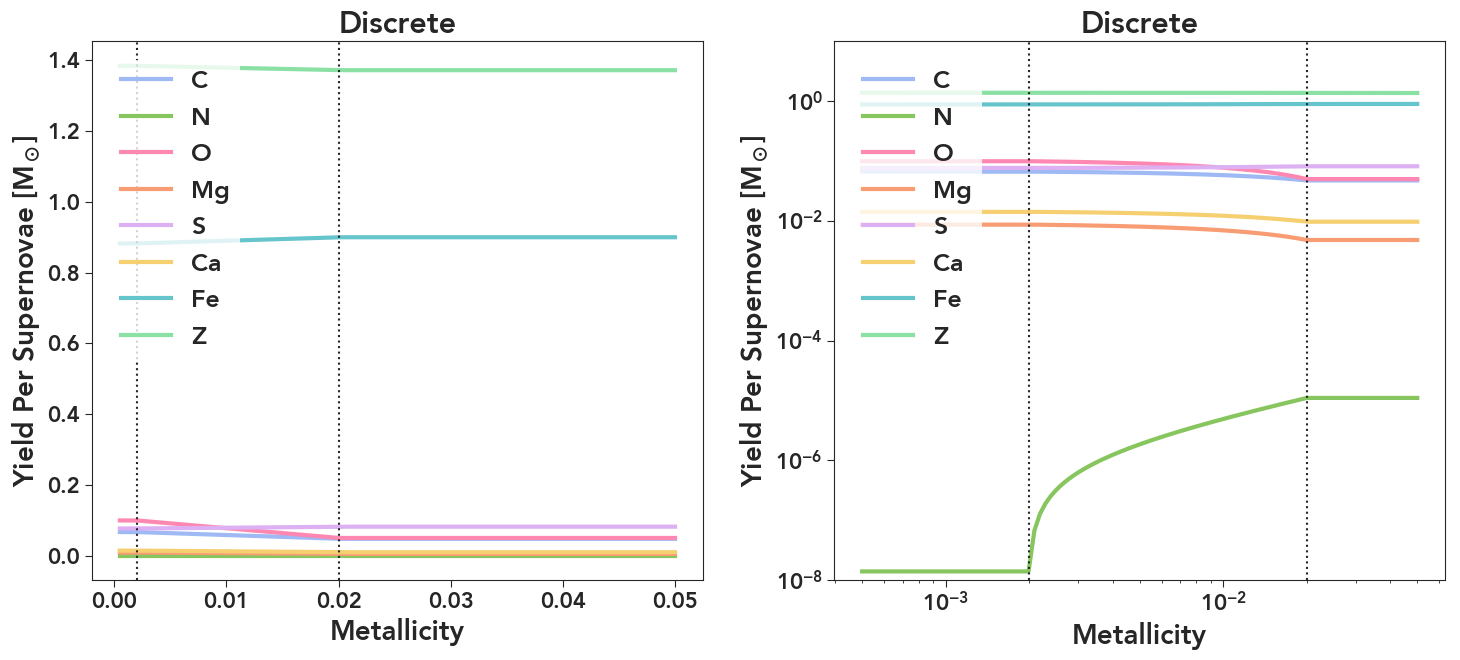

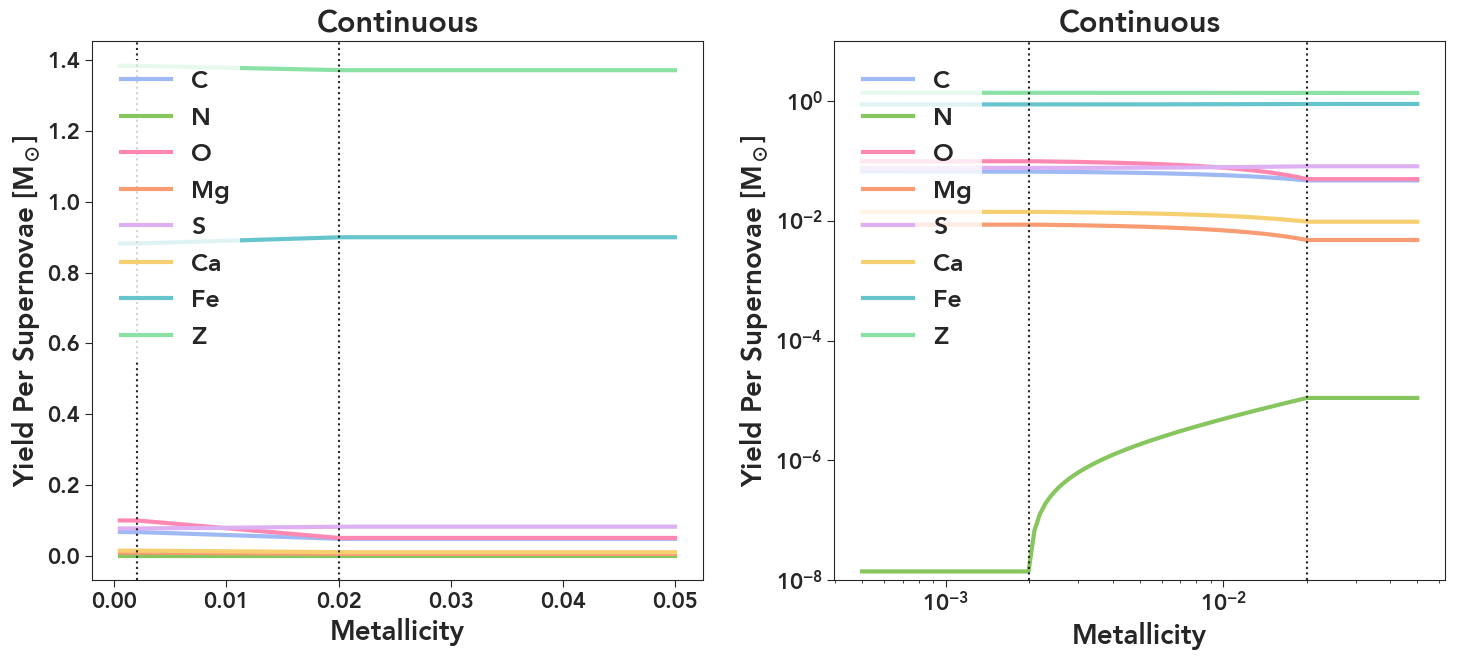

In [18]:
t = 1E8
dt_big = 1E9
m = 1E6

zs = np.linspace(0.0005, 0.05, 500)

for sn in all_snia:
    fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])
    
    yield_per_sn = defaultdict(list)
    n_unexploded = 0
    for z in zs:
        age_8 = lt.lifetime(8.0, z)
        
        n_sn_now = sn.snia_ejecta(n_unexploded, t, dt_big, m, z, age_8, "N_SN")

        for elt in elts:
            this_elt_yield = sn.snia_ejecta(n_unexploded, t, dt_big, m, z, age_8, elt)
            if n_sn_now > 0:
                yield_per_sn[elt].append(this_elt_yield / n_sn_now)
            else:
                yield_per_sn[elt].append(0)

        n_unexploded = sn.snia_ejecta(n_unexploded, t, dt_big, m, z, age_8, "N_SN_left")

    for elt in elts:
        for ax in axs:
            ax.plot(zs, yield_per_sn[elt], alpha=1, label=elt)

    for ax in axs:
        ax.add_labels("Metallicity", "Yield Per Supernovae [$M_\odot$]", sn.name)
        ax.legend(loc=2)
        ax.axvline(0.002, ls=":")
        ax.axvline(0.02, ls=":")

    axs[1].set_yscale("log")
    axs[1].set_xscale("log")
    axs[1].set_limits(y_min=1E-8, y_max=10)

This looks great! We've validated the key aspects of the code here.